# Project 2


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview


### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)
dtr = dataTraining.copy()
dte = dataTesting.copy()
dtr.head(2)

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6


In [3]:
dtr['year'] = dtr['year'].astype(int)
dtr.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
dte.head(3)

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...


Se imprime una muestra para ser utilizada en el API antes de aplicarle cualquier modificación a la base

In [5]:
print('Title: ')
print(dtr.iloc[4]['title'])
print('\n')
print('plot: ')
print(dtr.iloc[4]['plot'])
print('\n')
print('Genres: ')
print(dtr.iloc[4]['genres'])

Title: 
Narrow Margin


plot: 
in los angeles ,  the editor of a publishing house carol hunnicut goes to a blind date with the lawyer michael tarlow ,  who has embezzled the powerful mobster leo watts .  carol accidentally witnesses the murder of michel by leo ' s hitman .  the scared carol sneaks out of michael ' s room and hides in an isolated cabin in canada .  meanwhile the deputy district attorney robert caulfield and sgt .  dominick benti discover that carol is a witness of the murder and they report the information to caulfield ' s chief martin larner and they head by helicopter to canada to convince carol to testify against leo .  however they are followed and the pilot and benti are murdered by the mafia .  caulfield and carol flees and they take a train to vancouver .  caulfield hides carol in his cabin and he discloses that there are three hitman in the train trying to find carol and kill her .  but they do not know her and caulfield does not know who might be the third kill

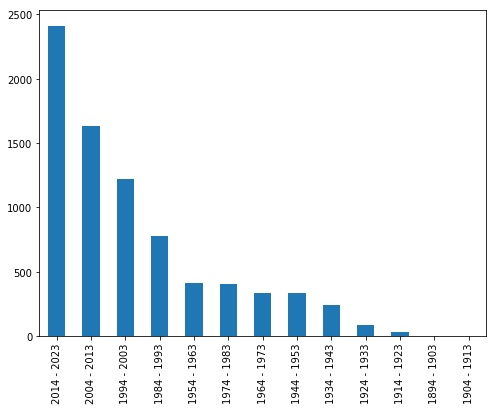

In [6]:
decades = ["{0} - {1}".format(age, age + 9) for age in range(min(dtr['year']), max(dtr['year'])+1, 10)]
count_unique_age_ranges = len(decades)
dtr['decades'] = pd.cut(x=dtr['year'], bins=count_unique_age_ranges, labels=decades)
pd.Series(dtr["decades"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 90)

se evidencia que desde 1984 el número de películas producidas ha aumentado significativamente.

In [7]:
df2 = dtr['genres'].map(lambda x: eval(str(x)))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(df2)
df2 = pd.DataFrame(y_genres, columns=le.classes_, index=dtr.index)
df = dtr.join(df2)
dc = {}
for i in df2.columns:
    dc[i] = (df2[i]==1).sum()
dc = pd.Series(dc, name='Count')
dc.index.name = 'Genres'
dc = dc.reset_index()
dc.index = dc['Genres']
dc = dc.drop('Genres', axis=1)
dc

,Count
Genres,
Action,1303
Adventure,1024
Animation,260
Biography,373
Comedy,3046
Crime,1447
Documentary,419
Drama,3965
Family,682


Drama, Comedy y Thriller son las que mayor número de películas tienen. 
News, Short y Film-Noir son las que menos tienen.

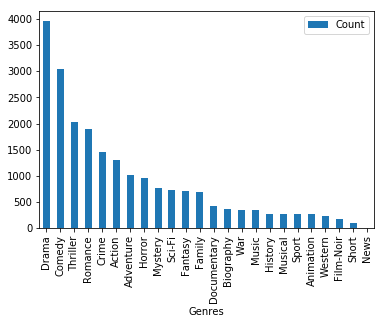

In [8]:
dc.sort_values('Count', ascending=False).plot.bar(stacked=True)

Creación de un Dataframe sobre el dataTraining separando los géneros para hacer algunos análisis descriptivos de los datos.

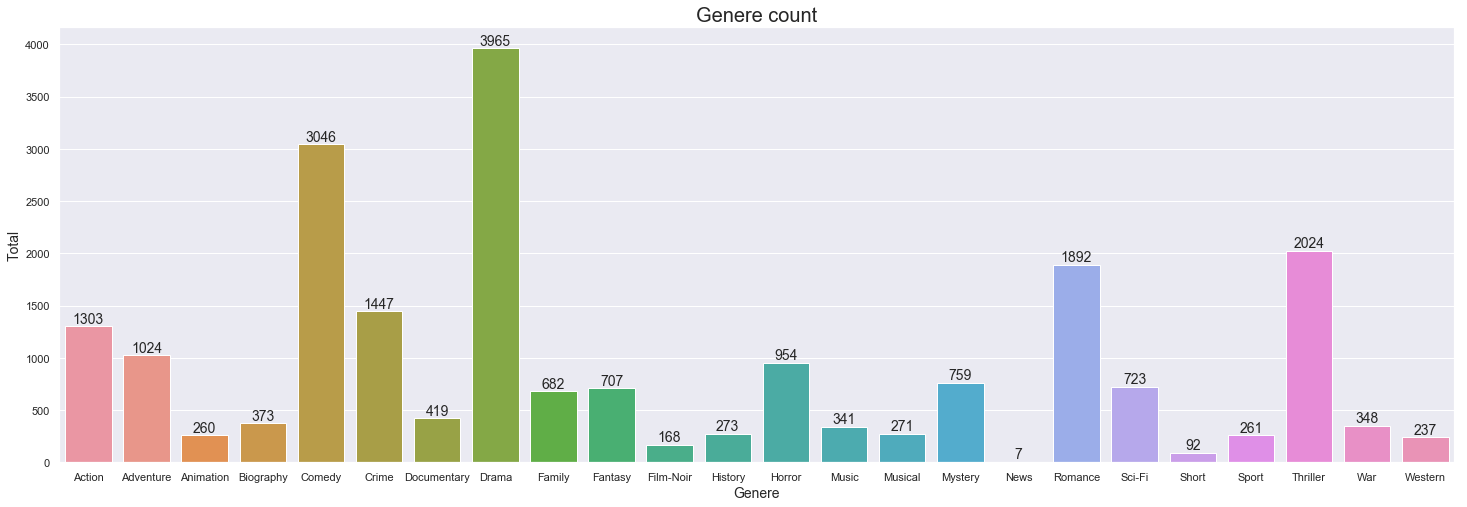

In [9]:
mlb = MultiLabelBinarizer()
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
trainExploreDF = dataTraining.join(pd.DataFrame(mlb.fit_transform(dataTraining.pop('genres')),
                          columns=mlb.classes_,
                          index=dataTraining.index))

categories = list(trainExploreDF.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(25,8))
ax= sns.barplot(categories[4:], trainExploreDF.iloc[:,4:].sum().values)
plt.title('Genere count', fontsize=20)
plt.ylabel('Total', fontsize=14)
plt.xlabel('Genere', fontsize=14)
#adding the text labels
rects = ax.patches
labels = trainExploreDF.iloc[:,4:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 3, label, ha='center', va='bottom', fontsize=14)
plt.show()

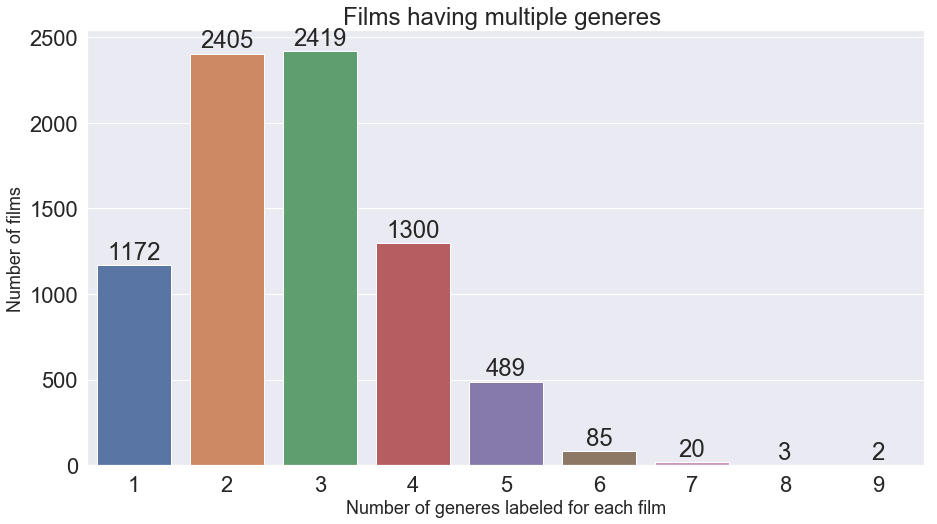

In [10]:
rowSums = trainExploreDF.iloc[:,4:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts=multiLabel_counts.sort_index()
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Films having multiple generes ")
plt.ylabel('Number of films', fontsize=18)
plt.xlabel('Number of generes labeled for each film', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

En la base de datos de entrenamiento es más probable que cada película esté etiquetada con 2 o 3 géneros a la vez, seguida de 4 y 1 géneros. Es poco probable que una película esté etiquetada con mas de 6 géneros a la vez. Todas las películas tienen al menos una etiqueta.

In [11]:
dtr["plot"] = dtr["plot"].astype(str)
data = dtr["plot"]
data = dtr.loc[np.random.choice(dtr.index, size=2000)]
categories = list(df2.columns.values)

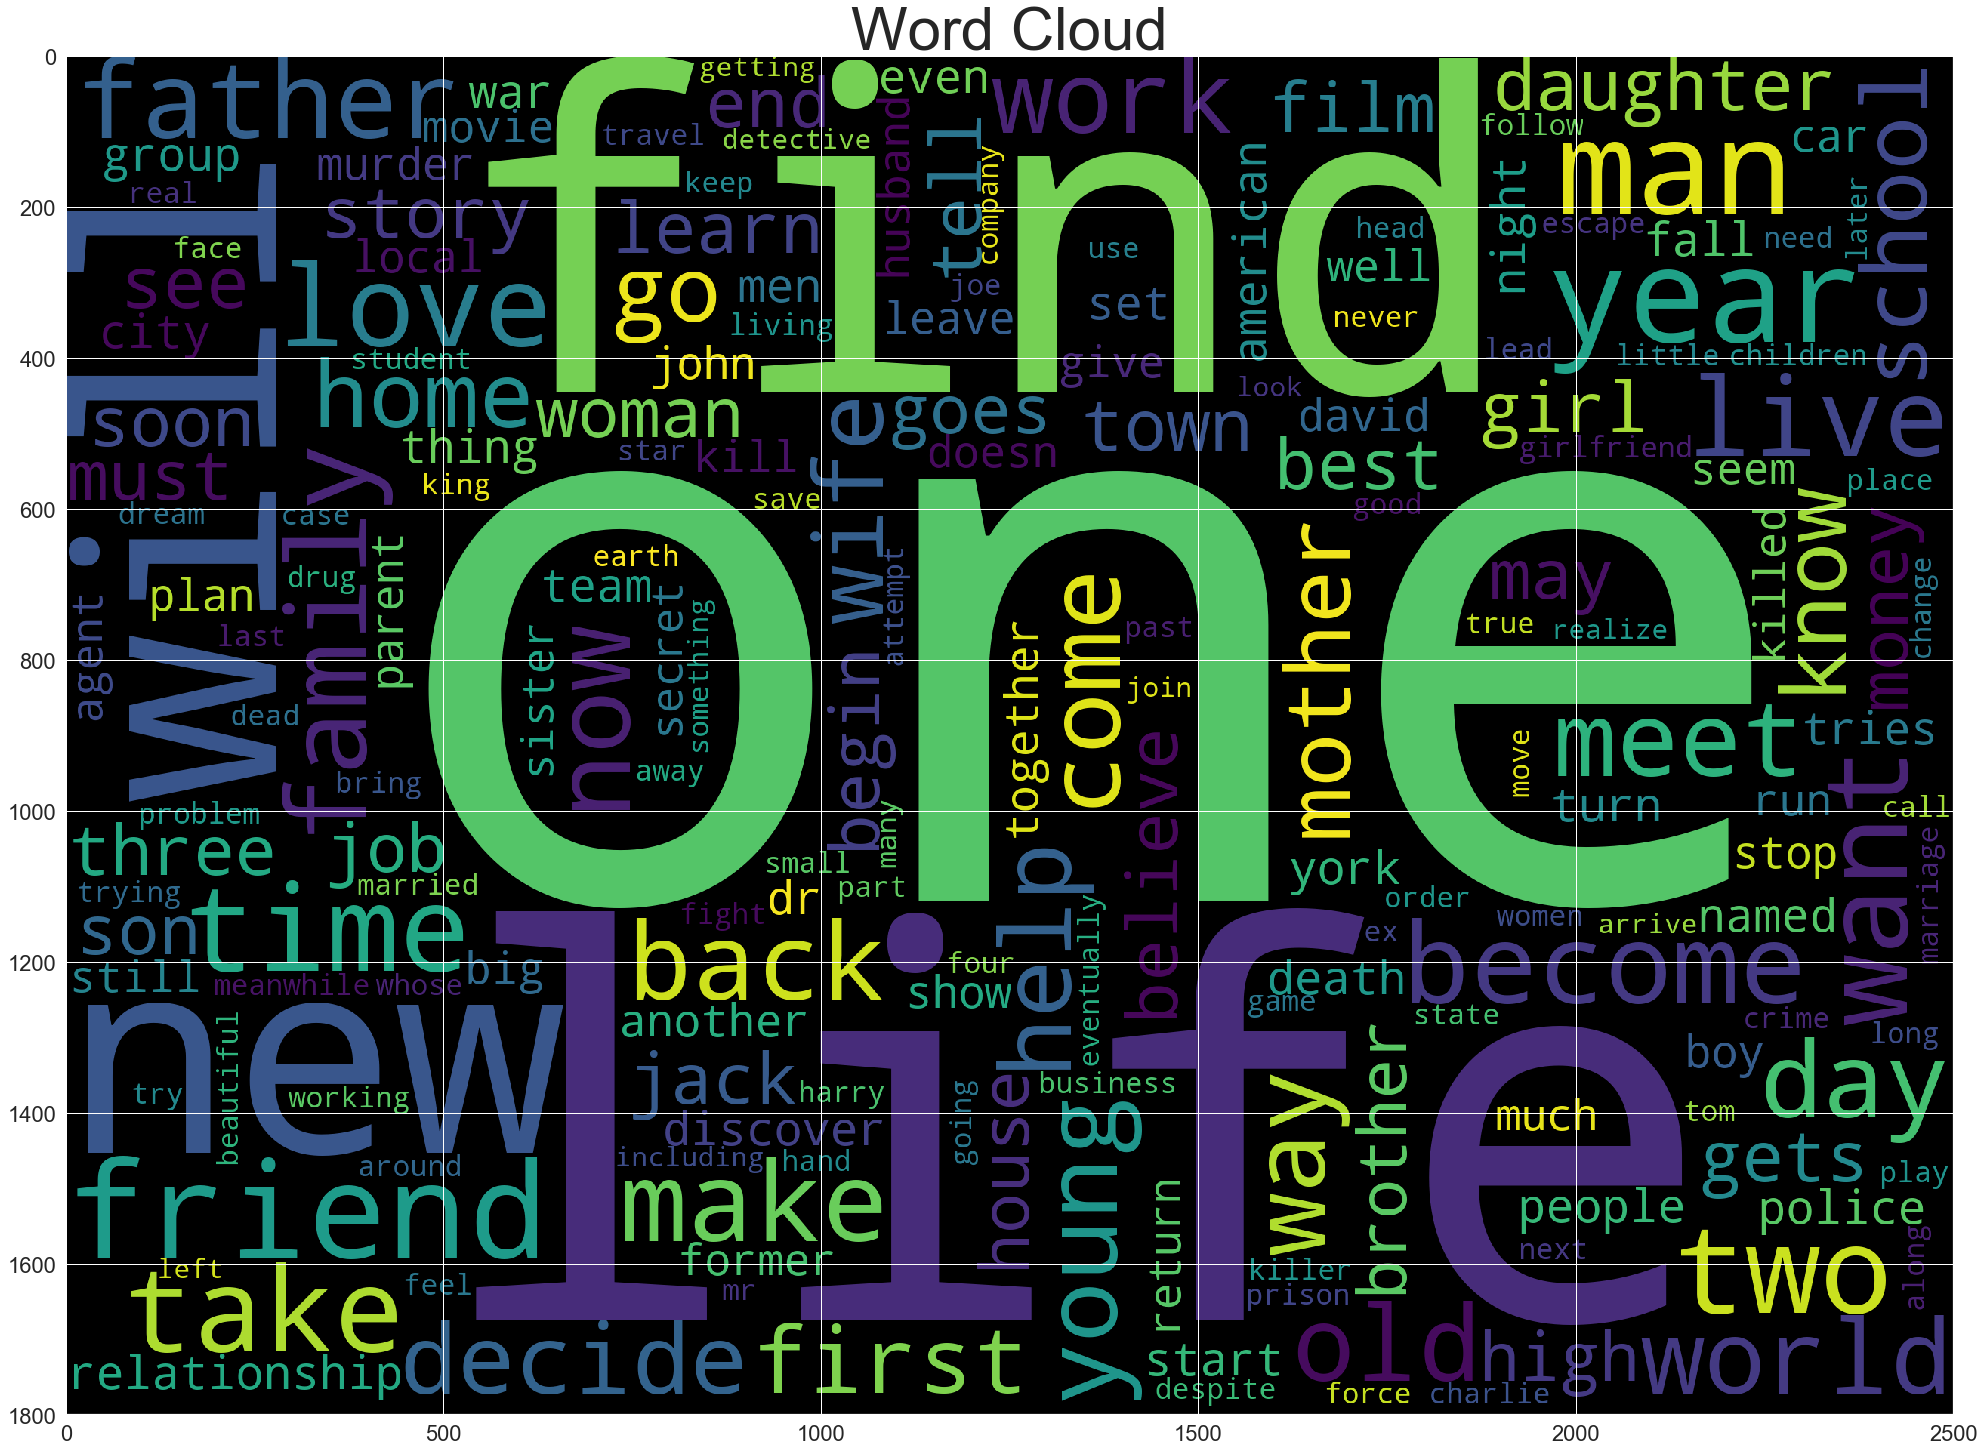

In [12]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# toxic
subset = data["plot"]
text = subset.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.title("Word Cloud",fontsize=60)
plt.imshow(cloud_toxic)

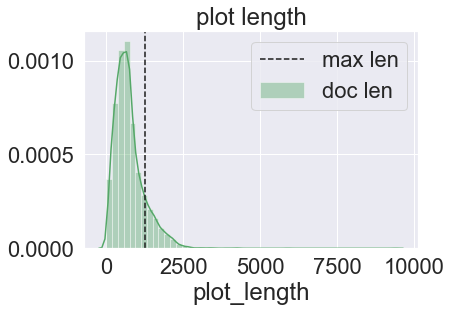

In [13]:
#visualize word distribution
trainExploreDF['plot_length'] = trainExploreDF['plot'].apply(lambda words: len(words))
max_seq_len = np.round(trainExploreDF['plot_length'].mean() + trainExploreDF['plot_length'].std()).astype(int)
sns.distplot(trainExploreDF['plot_length'], hist=True, kde=True, color='g', label='doc len')
#sns.distplot(dataTesting['plot'].apply(lambda words: len(words)), hist=True, kde=True, color='b', label='Test')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

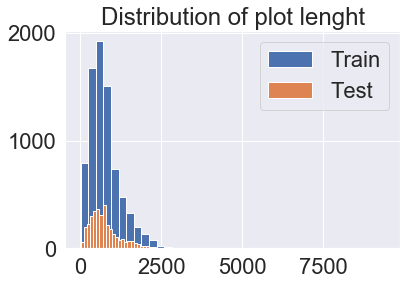

In [14]:
plt.hist(dataTraining['plot'].apply(lambda words: len(words)), bins=40, label='Train')
plt.hist(dataTesting['plot'].apply(lambda words: len(words)), bins=40, label='Test')
plt.title('Distribution of plot lenght')
plt.legend()
y_genres = trainExploreDF.iloc[:,4:-1]

Más adelante se eliminarán de las descripciones aquellas palabras (top 10) que más y menos se repiten. 

Adicionalmente vamos a juntar tanto el título como el plot de los registros en un solo campo.

In [15]:
data = dtr
data['plot'] = data['title'] + ' '+ data['plot']

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
data.head(3)

,year,title,plot,genres,rating,decades
3107,2003,Most,Most most is the story of a single father who ...,"['Short', 'Drama']",8.0,2004 - 2013
900,2008,How to Be a Serial Killer,How to Be a Serial Killer a serial killer deci...,"['Comedy', 'Crime', 'Horror']",5.6,2014 - 2023
6724,1941,A Woman's Face,"A Woman's Face in sweden , a female blackmail...","['Drama', 'Film-Noir', 'Thriller']",7.2,1944 - 1953


# Aplicando funciones de pre-procesamiento de texto
En este paso aplicamos las funciones anteriormente creadas para Eliminar puntuación y cualquier simbolo que pueda representar ruido en la clasificación 

In [17]:
data['plot'] = data['plot'].str.lower()
data['plot'] = data['plot'].apply(cleanHtml)
data['plot'] = data['plot'].apply(cleanPunc)
data['plot'] = data['plot'].apply(keepAlpha)
data.head()

,year,title,plot,genres,rating,decades
3107,2003,Most,most most is the story of a single father who ...,"['Short', 'Drama']",8.0,2004 - 2013
900,2008,How to Be a Serial Killer,how to be a serial killer a serial killer deci...,"['Comedy', 'Crime', 'Horror']",5.6,2014 - 2023
6724,1941,A Woman's Face,a womans face in sweden a female blackmailer w...,"['Drama', 'Film-Noir', 'Thriller']",7.2,1944 - 1953
4704,1954,Executive Suite,executive suite in a friday afternoon in new y...,['Drama'],7.4,1954 - 1963
2582,1990,Narrow Margin,narrow margin in los angeles the editor of a p...,"['Action', 'Crime', 'Thriller']",6.6,1994 - 2003


In [18]:
# Eliminando Stop Words de la muestra

In [19]:
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['plot'] = data['plot'].apply(removeStopWords)
data.head()

,year,title,plot,genres,rating,decades
3107,2003,Most,story single father takes eight year ...,"['Short', 'Drama']",8.0,2004 - 2013
900,2008,How to Be a Serial Killer,serial killer serial killer decides teac...,"['Comedy', 'Crime', 'Horror']",5.6,2014 - 2023
6724,1941,A Woman's Face,womans face sweden female blackmailer dis...,"['Drama', 'Film-Noir', 'Thriller']",7.2,1944 - 1953
4704,1954,Executive Suite,executive suite friday afternoon new york ...,['Drama'],7.4,1954 - 1963
2582,1990,Narrow Margin,narrow margin los angeles editor publishin...,"['Action', 'Crime', 'Thriller']",6.6,1994 - 2003


# Eliminando las palabras más frecuentes y más raras de 'plot'
Como estamos realizando un proceso de clasificación según la descripción de la película, consideramos que las palabras más frecuentes no aportan mucho al momento de la clasificación puesto que pueden estar presentes en más de una categoria

In [20]:
freq = pd.Series(' '.join(data['plot']).split()).value_counts()[:10]
freq = list(freq.index)
print('Top 10 de palabras más frecuentes:')
print(freq)
data['plot'] = data['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
freq = pd.Series(' '.join(data['plot']).split()).value_counts()[-10:]
freq = list(freq.index)
print('Top 10 de palabras menos frecuentes:')
print(freq)
data['plot'] = data['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

Top 10 de palabras más frecuentes:
['n', 'one', 'life', 'new', 'man', 'two', 'get', 'family', 'love', 'father']
Top 10 de palabras menos frecuentes:
['meester', 'taijii', 'wilk', 'liling', 'loudspeaker', 'visioneers', 'martyr', 'groundskeeper', 'kierney', 'warszaw']


# Preprocesamiento de Stemming 
método para reducir una palabra a su raíz.

In [21]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['plot'] = data['plot'].apply(stemming)
data.head()

,year,title,plot,genres,rating,decades
3107,2003,Most,stori singl take eight year old son work railr...,"['Short', 'Drama']",8.0,2004 - 2013
900,2008,How to Be a Serial Killer,serial killer serial killer decid teach secret...,"['Comedy', 'Crime', 'Horror']",5.6,2014 - 2023
6724,1941,A Woman's Face,woman face sweden femal blackmail disfigur fac...,"['Drama', 'Film-Noir', 'Thriller']",7.2,1944 - 1953
4704,1954,Executive Suite,execut suit friday afternoon york presid tredw...,['Drama'],7.4,1954 - 1963
2582,1990,Narrow Margin,narrow margin los angel editor publish hous ca...,"['Action', 'Crime', 'Thriller']",6.6,1994 - 2003


# Vectorizando con TD-IDF el campo 'plot' y desarrollando un modelo Logistico de regresión para la clasificación

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
vect = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=1, max_df=0.4, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_dtm = vect.fit_transform(data['plot'])
data['genres'] = data['genres'].map(lambda x: eval(str(x)))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(data['genres'])
x_train, x_test, y_train, y_test = train_test_split(X_dtm, y_genres, test_size=0.3, random_state=42)

In [23]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
#LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42), n_jobs=-1))])
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(C=1, dual=True,class_weight='balanced',multi_class='auto',solver='liblinear'), n_jobs=-1))])
LogReg_pipeline.fit(x_train, y_train)    
y_pred = LogReg_pipeline.predict_proba(x_test)
roc_auc_score(y_test, y_pred, average='macro')

0.8886465271982944

Se realiza un modelo Logístico multi-clase y al realizar la predicción sobre un set de entrenamiento y prueba, se identifica un AUC superior 0.8 (en Kaggle este modelo marca 0.896).

Adicionalmente, se propone unificar el título con la descripción en un solo campo tanto para el set de entrenamiento como en el de prueba.

# Preparando el set de test y realizando las predicciones sobre cada registro

In [24]:
dte['plot'] = dte['title']+' '+dte['plot']
dte['plot'] = dte['plot'].str.lower()
dte['plot'] = dte['plot'].apply(cleanHtml)
dte['plot'] = dte['plot'].apply(cleanPunc)
dte['plot'] = dte['plot'].apply(keepAlpha)
dte['plot'] = dte['plot'].apply(removeStopWords)
dte['plot'] = dte['plot'].apply(stemming)
dte.head(3)

,year,title,plot
1,1999,Message in a Bottle,messag bottl meet fate shall seal fate theresa...
4,1978,Midnight Express,midnight express true stori billi hay american...
5,1996,Primal Fear,primal fear martin vail left chicago da offic ...


In [25]:
X_test_dtm = vect.transform(dte['plot'])
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = LogReg_pipeline.predict_proba(X_test_dtm)

In [26]:
res = pd.DataFrame(y_pred_test_genres, index=dte.index, columns=cols)
res.to_csv('pred_genres_text_LOG.csv', index_label='ID')
res.head(10)

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.252277,0.308093,0.144531,0.151295,0.504468,0.306614,0.128904,0.549998,0.217927,0.357551,...,0.202820,0.358008,0.012114,0.651777,0.215742,0.087665,0.170863,0.378189,0.107533,0.153189
4,0.351333,0.163771,0.151219,0.601517,0.307559,0.533770,0.276751,0.707241,0.155224,0.131363,...,0.172483,0.173276,0.018796,0.245281,0.111740,0.082348,0.202067,0.421549,0.281936,0.160892
5,0.277273,0.118302,0.074303,0.235218,0.253078,0.789179,0.120168,0.746610,0.101263,0.163911,...,0.109982,0.754549,0.012593,0.375766,0.216894,0.053765,0.139425,0.729723,0.177576,0.103094
6,0.347813,0.302365,0.096347,0.191175,0.330107,0.305661,0.116514,0.675957,0.198768,0.221324,...,0.210934,0.368144,0.014168,0.506933,0.339450,0.056801,0.176169,0.565465,0.332662,0.133271
7,0.264355,0.242600,0.160176,0.186836,0.318926,0.301991,0.167266,0.393831,0.244652,0.404739,...,0.127048,0.366741,0.013187,0.310320,0.753892,0.084997,0.096294,0.476304,0.107348,0.113894
9,0.341363,0.283895,0.154777,0.345566,0.349374,0.341399,0.299857,0.596489,0.190181,0.262896,...,0.178152,0.256852,0.013324,0.302053,0.239074,0.096042,0.209228,0.411347,0.192980,0.118506
11,0.361633,0.326538,0.202475,0.478397,0.348372,0.353623,0.722288,0.415263,0.333052,0.289347,...,0.255193,0.119538,0.021462,0.408542,0.245639,0.104807,0.298073,0.238622,0.113971,0.119994
13,0.441771,0.216817,0.121766,0.121966,0.637408,0.653833,0.068789,0.554297,0.288220,0.234991,...,0.185057,0.202307,0.011974,0.444019,0.180723,0.071731,0.117810,0.538290,0.149376,0.107375
16,0.189531,0.208606,0.084774,0.161698,0.453704,0.254203,0.110089,0.710137,0.218692,0.264027,...,0.148312,0.364276,0.012931,0.673585,0.223111,0.052583,0.099498,0.376781,0.150167,0.106717
21,0.241413,0.308361,0.217424,0.188988,0.691117,0.306334,0.171150,0.574315,0.336087,0.278015,...,0.218590,0.189312,0.013040,0.513973,0.214612,0.080952,0.168902,0.233093,0.146029,0.155313


Luego se entrena el modelo con el 100% de los datos de Train para generar el archivo de subida a Kaggle.

In [27]:
LogReg_pipeline.fit(X_dtm, y_genres)    
y_pred_test_genres = LogReg_pipeline.predict_proba(X_test_dtm)
res = pd.DataFrame(y_pred_test_genres, index=dte.index, columns=cols)
res.to_csv('pred_genres_text_LOG_Final.csv', index_label='ID')
res.head(10)

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.262222,0.292680,0.151077,0.135396,0.453873,0.299859,0.112341,0.598304,0.240698,0.363133,...,0.174234,0.416271,0.013305,0.637531,0.213414,0.075365,0.139264,0.381003,0.111901,0.141869
4,0.349561,0.136559,0.133346,0.663931,0.309770,0.551031,0.279515,0.774881,0.147346,0.098012,...,0.181834,0.172970,0.022946,0.238142,0.089034,0.079435,0.203299,0.442210,0.295583,0.122654
5,0.251174,0.085222,0.047061,0.264948,0.178962,0.841430,0.109129,0.787453,0.075762,0.129048,...,0.080281,0.803069,0.020370,0.350416,0.172516,0.045788,0.132393,0.778359,0.159437,0.095666
6,0.325349,0.305880,0.105305,0.195674,0.267846,0.277982,0.090517,0.685314,0.198555,0.194970,...,0.176672,0.386996,0.014892,0.448380,0.384850,0.052122,0.146927,0.579981,0.383294,0.160073
7,0.215836,0.260141,0.186225,0.152939,0.302380,0.253612,0.155766,0.315120,0.224084,0.436052,...,0.110195,0.362606,0.013643,0.265078,0.841138,0.079314,0.067405,0.539634,0.072321,0.095750
9,0.365312,0.299912,0.150697,0.473544,0.299970,0.300853,0.302142,0.651062,0.231217,0.230094,...,0.156768,0.227117,0.015373,0.300285,0.201597,0.088375,0.239545,0.382759,0.173816,0.113390
11,0.353207,0.270592,0.215195,0.613777,0.332460,0.415777,0.814095,0.401759,0.302761,0.253398,...,0.367616,0.083658,0.031209,0.416419,0.222043,0.087274,0.278562,0.209802,0.094397,0.115749
13,0.484625,0.170752,0.103408,0.109939,0.659141,0.712270,0.052192,0.598984,0.296895,0.234659,...,0.149505,0.164331,0.012466,0.464118,0.164044,0.058856,0.115529,0.527875,0.117896,0.107281
16,0.130965,0.163503,0.070473,0.143491,0.495210,0.199499,0.081366,0.776223,0.198315,0.205539,...,0.129355,0.353912,0.013575,0.763493,0.181174,0.042893,0.083157,0.326611,0.153086,0.083882
21,0.210132,0.287123,0.224311,0.177303,0.726266,0.279197,0.143449,0.557432,0.382956,0.291614,...,0.230964,0.149468,0.015000,0.528403,0.183627,0.073415,0.154790,0.213089,0.116013,0.137460


Se puede observar que las probabilidades aumentan o disminuyen ya utilizando el 100% de los datos de entrenamiento para hacer un fit en el modelo. 

A continuación, se guarda tanto el modelo como el vector TF-IDF para reproducirlo en el API.

# Guardando los resultados

In [28]:
from sklearn.externals import joblib
# Save the trained model as a pickle string. 
joblib.dump(LogReg_pipeline, 'LogReg.sav') 
joblib.dump(vect, 'vectroizer.pkl')

['vectroizer.pkl']